In [84]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt

### Fossil Fuel Subsidies

Note that we need to keep values titled "NA" because that's Namibia's ISO2 code. Also, Kosovo doesn't have an ISO3 so we can't use that.

In [39]:
subsidy = pd.read_csv('input/policy/Fossil_Fuel_Subsidies.csv', index_col=0, keep_default_na=False, na_values="")
subsidy.head(3)

,Country,ISO2,ISO3,Indicator,Source,CTS_Code,CTS_Name,CTS_Full_Descriptor,Unit,F2015,F2016,F2017,F2018,F2019,F2020,F2021,F2022,F2023,F2024,F2025
ObjectId,,,,,,,,,,,,,,,,,,,,
1,"Afghanistan, Islamic Rep. of",AF,AFG,Explicit Fossil Fuel Subsidies - Coal,"Parry, Ian; Black, Simon; Vernon, Nate. Septem...",ECGFTEC,Explicit; Coal,"Environment, Climate Change, Government Policy...",Percent of GDP,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Afghanistan, Islamic Rep. of",AF,AFG,Explicit Fossil Fuel Subsidies - Coal,"Parry, Ian; Black, Simon; Vernon, Nate. Septem...",ECGFTEC,Explicit; Coal,"Environment, Climate Change, Government Policy...",US Dollars,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Afghanistan, Islamic Rep. of",AF,AFG,Explicit Fossil Fuel Subsidies - Electricity,"Parry, Ian; Black, Simon; Vernon, Nate. Septem...",ECGFTET,Explicit; Electricity,"Environment, Climate Change, Government Policy...",Percent of GDP,0.0,0.0,0.0,0.083287,0.375834,0.075661,0.252216,0.247982,0.270226,0.271118,0.245831


In [40]:
country_nodes = subsidy.ISO2.unique()
policy_nodes = subsidy.CTS_Code.unique()
print("Number of Countries:", len(country_nodes))
print("Number of Subsidies:", len(policy_nodes))

Number of Countries: 197
Number of Subsidies: 21


Another question would be how do we create groups of subsidies. We'll call the fossil fuel subsidy bi-partite graph S.

In [41]:
S = nx.Graph()
S.add_nodes_from(country_nodes, bipartite=0)
S.add_nodes_from(policy_nodes, bipartite=1)

Note that the following countries do not have the Petroleum field. We'll simply not draw edges.

In [42]:
full = set(subsidy[subsidy.ISO2 == "AF"].CTS_Name)
subsidy_sub = subsidy[subsidy.Unit == "Percent of GDP"]
for country in country_nodes:
    subset = subsidy_sub[subsidy_sub.ISO2 == country]
    if len(subset) < 21:
        print(country, len(subset))
        partial = set(subsidy[subsidy.ISO2 == country].CTS_Name)
        print(full - partial)

AI 20
{'Implicit; Petroleum'}
MH 20
{'Implicit; Petroleum'}
PW 20
{'Implicit; Petroleum'}
SM 20
{'Implicit; Petroleum'}
TV 20
{'Implicit; Petroleum'}


Loop through every country/policy combination and add an edge if the value for specified year was greater than 0.

In [43]:
df_temp = subsidy[subsidy.Unit == "Percent of GDP"]
df_temp.set_index(["ISO2", "CTS_Code"], inplace = True)
edge_list = []
year = "F2018"

for country in country_nodes:
    subset = df_temp.loc[country]
    for policy_code in subset.index:
        weight = subset.loc[policy_code][year]
        if weight > 0:
            edge = (country, policy_code, weight)
            edge_list.append(edge)

S.add_weighted_edges_from(edge_list)

In [44]:
print("Number of Edges:", S.number_of_edges())
print("Number of Possible Edges:", len(country_nodes) * len(policy_nodes))

Number of Edges: 2825
Number of Possible Edges: 4137


### Green Bonds

##### Intro

In [2]:
green_bonds = pd.read_csv("input/policy/Green_Bonds.csv", index_col=0, keep_default_na=False, na_values="")

# Filtered Down to countries
green_bonds = green_bonds[np.logical_not(green_bonds["ISO2"].isna())]

green_bond_country_nodes = green_bonds.ISO2.unique()

# Need to figure out the differences between these bonds
bonds_nodes = green_bonds["CTS_Name"].unique()

Looks likes most years no one invested in bonds. Still very few countries invest in bonds but each year it seems the number increases.

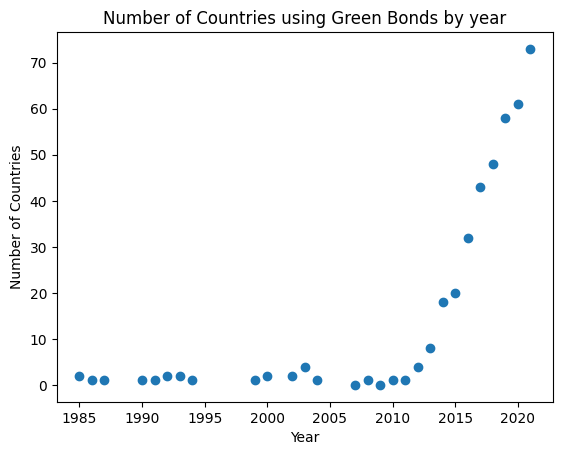

In [3]:
# Get the data
num_countries = green_bonds[green_bonds.columns[12:]].count().to_list()
years = [int(year[1:]) for year in green_bonds.columns[12:]]

# Plot
fig,ax = plt.subplots()
ax.scatter(years, num_countries)
ax.set_title("Number of Countries using Green Bonds by year")
ax.set_ylabel("Number of Countries")
ax.set_xlabel("Year")

plt.show()

Furthermore we can break the graph down into its two different categories

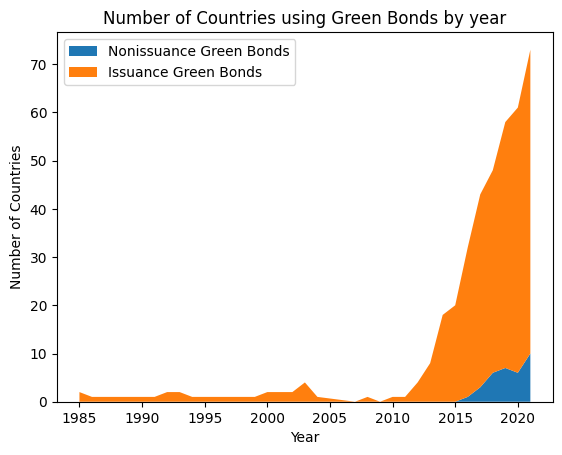

In [4]:
# Get the data
issuances = green_bonds[green_bonds["CTS_Name"] == "Green Bonds Issuances"]

# Calculate Variables
issuance_count = issuances[issuances.columns[12:]].count()
nonissuance_count = num_countries - issuance_count
y = np.vstack([nonissuance_count, issuance_count])

# Plot
fig,ax = plt.subplots()
# Using years var from last cell
ax.stackplot(years, y, labels = ["Nonissuance Green Bonds", "Issuance Green Bonds",])
ax.set_title("Number of Countries using Green Bonds by year")
ax.set_ylabel("Number of Countries")
ax.set_xlabel("Year")
ax.legend(loc = "upper left")

plt.show()

##### Graph Building

Initializing the nodes in our bipartite graph. Country nodes are on the left and green bond policies are on the right.

In [60]:
B = nx.Graph()
B.add_nodes_from(green_bond_country_nodes, bipartite=0)
B.add_nodes_from(bonds_nodes, bipartite=1)

We are creating the edge_lists for every single year. This can allow for quick creation of graphs for any specific year.

In [56]:
green_bonds_temp = green_bonds.set_index(["ISO2", "CTS_Name"], inplace = False)
dict = {}
for year in green_bonds.columns[12:]: #create edge lists for each year
    edge_list = []
    for country in green_bond_country_nodes: #find every country-bond combo
        subset = green_bonds_temp.loc[country]
        for bond in subset.index: #bond
            weight = subset.loc[bond][year] #edge weights are bond values
            if weight > 0:
                edge = (country, bond, weight) #create edge
                edge_list.append(edge)
    dict[int(year[1:])] = edge_list

Let's create a graph for 2015 and see what it looks like:

In [81]:
B.remove_edges_from(B.edges)
B.add_weighted_edges_from(dict[2015])
print("Number of Edges:", B.number_of_edges())
print("Number of Possible Edges:", len(green_bond_country_nodes) * len(bonds_nodes))

Number of Edges: 20
Number of Possible Edges: 152


Let's also create a method to see the number of countries implementing any policies at all:

In [95]:
def country_count(B, country_nodes):
    deg_policy, deg_country = bipartite.degrees(B, country_nodes)
    sum = 0
    for c, d in deg_country:
        if d > 0:
            sum += 1
    return sum
print("Participating Countries:", country_count(B, green_bond_country_nodes))

Participating Countries: 20


##### Analysis

Temporal graph creation:

In [96]:
results = []
for year in years:
    B.remove_edges_from(B.edges)
    B.add_weighted_edges_from(dict[year])
    countries = country_count(B, green_bond_country_nodes) #participating countries
    results.append({"Year": year, "Countries": countries, "Edges": B.number_of_edges()})
pd.DataFrame(results)

,Year,Countries,Edges
0,1985,2,2
1,1986,1,1
2,1987,1,1
3,1990,0,0
4,1991,1,1
5,1992,2,2
6,1993,2,2
7,1994,1,1
8,1999,1,1
9,2000,2,2


Things to implement temporally: (loop through every year, show how these change)
- number of nodes (remove those without any edges)
- number of edges (weighted)
- number of trianges -> metamorphis coefficient
- change point detection
- any other correlation measures

Node based metrics:
- harmonic, closeness, degree, & eigenvector centralities
- you can show how it changes over time

Clustering:
- find out how to cluster bipartite graphs
- change point detection

### Environmental Taxes

First lets load in the data and take a quick peak.  The final table is a table about how many measures each country implements.

In [104]:
taxes = pd.read_csv("input/policy/Environmental_Taxes.csv")

num_countries = len(taxes["Country"].unique())
print(f"There are {num_countries} unique countries that are implementing environmental taxes")
print("Each country typically reports 10 different measures, but there are a few that report less than 10 measures")

taxes.Country.value_counts().value_counts()

There are 124 unique countries that are implementing environmental taxes
Each country typically reports 10 different measures, but there are a few that report less than 10 measures


10    118
8       3
6       1
5       1
4       1
Name: Country, dtype: int64

In [105]:
country_nodes = taxes.ISO2.unique()
policy_nodes = taxes.CTS_Code.unique()
print("Number of Countries:", len(country_nodes))
print("Number of Subsidies:", len(policy_nodes))

T = nx.Graph()
T.add_nodes_from(country_nodes, bipartite=0)
T.add_nodes_from(policy_nodes, bipartite=1)

Number of Countries: 124
Number of Subsidies: 5


In [106]:
edges = []
year = "F2018"
taxes_sub = taxes[taxes.Unit == "Percent of GDP"]
for country in country_nodes:
    subset = taxes_sub[taxes_sub.ISO2 == country]
    for policy in policy_nodes:
        weight = subset[subset.CTS_Code == policy][year].values
        if weight > 0:
            edge = (country, policy, weight[0])
            edges.append(edge)

/var/folders/pf/50hvlj9x3gq8h7y4md057b3r0000gn/T/ipykernel_95744/2768913331.py:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if weight > 0:


In [107]:
T.add_weighted_edges_from(edges)
print("Number of Edges:", T.number_of_edges())
print("Number of Possible Edges:", len(country_nodes) * len(policy_nodes))

Number of Edges: 415
Number of Possible Edges: 620


### Environmental Protection Expenditures

In [108]:
expenditures = pd.read_csv("input/policy/Environmental_Protection_Expenditures.csv", index_col=0, keep_default_na=False, na_values="")
expenditures.head(5)

,Country,ISO2,ISO3,Indicator,Source,CTS_Code,CTS_Name,CTS_Full_Descriptor,Unit,F1995,...,F2012,F2013,F2014,F2015,F2016,F2017,F2018,F2019,F2020,F2021
ObjectId,,,,,,,,,,,,,,,,,,,,,
1,"Afghanistan, Islamic Rep. of",AF,AFG,Expenditure on biodiversity & landscape protec...,"International Monetary Fund (IMF), Statistics ...",GENB_G14,Expenditure on Biodiversity & Landscape Protec...,"Government and Public Sector Finance, Expendit...",Domestic Currency,NaN,...,NaN,NaN,NaN,NaN,1.243785e+08,1.258269e+09,NaN,NaN,NaN,NaN
2,"Afghanistan, Islamic Rep. of",AF,AFG,Expenditure on biodiversity & landscape protec...,"International Monetary Fund (IMF), Statistics ...",GENB_G14,Expenditure on Biodiversity & Landscape Protec...,"Government and Public Sector Finance, Expendit...",Percent of GDP,NaN,...,NaN,NaN,NaN,NaN,9.433491e-03,9.134202e-02,NaN,NaN,NaN,NaN
3,"Afghanistan, Islamic Rep. of",AF,AFG,Expenditure on environment protection,"International Monetary Fund (IMF), Statistics ...",GEN_G14,Environmental Protection Expenditures,"Government and Public Sector Finance, Expendit...",Domestic Currency,NaN,...,2.846995e+09,3.344665e+09,2.204964e+09,1.122601e+09,1.702933e+09,2.377937e+09,NaN,NaN,NaN,NaN
4,"Afghanistan, Islamic Rep. of",AF,AFG,Expenditure on environment protection,"International Monetary Fund (IMF), Statistics ...",GEN_G14,Environmental Protection Expenditures,"Government and Public Sector Finance, Expendit...",Percent of GDP,NaN,...,2.754469e-01,2.994793e-01,1.863813e-01,9.152359e-02,1.291590e-01,1.726226e-01,NaN,NaN,NaN,NaN
5,"Afghanistan, Islamic Rep. of",AF,AFG,Expenditure on environmental protection n.e.c.,"International Monetary Fund (IMF), Statistics ...",GENO_G14,Expenditure on Environmental Protection Not El...,"Government and Public Sector Finance, Expendit...",Domestic Currency,NaN,...,NaN,NaN,NaN,NaN,9.669078e+07,8.846917e+07,NaN,NaN,NaN,NaN


In [109]:
country_nodes = expenditures.ISO2.unique()
policy_nodes = expenditures.CTS_Code.unique()
print("Number of countries:", len(country_nodes))
print("Number of expenditures:", len(policy_nodes))

E = nx.Graph()
E.add_nodes_from(country_nodes, bipartite=0)
E.add_nodes_from(policy_nodes, bipartite=1)

Number of countries: 129
Number of expenditures: 7


In [110]:
edges = []
year = "F2018"

exp_sub = expenditures[expenditures.Unit == "Percent of GDP"]
for country in country_nodes:
    subset = exp_sub[exp_sub.ISO2 == country]
    for policy in policy_nodes:
        weight = subset[subset.CTS_Code == policy][year].values
        if weight.size > 0 and weight > 0:
            edge = (country, policy, weight[0])
            edges.append(edge)

In [111]:
print("Number of possible edges:", len(country_nodes) * len(policy_nodes))
print("Number of edges:", len(edges))

Number of possible edges: 903
Number of edges: 495


### Analysis

In [112]:
for comp in nx.connected_components(B):
    print(comp)

{'AR'}
{'CA', 'NZ', 'AE', 'Green Bonds Issuances', 'GB', 'US', 'MX', 'FR', 'BR', 'CN', 'NL', 'EE', 'HK', 'DK', 'SE', 'NO', 'AU', 'IN', 'JP', 'DE', 'LV'}
{'AT'}
{'BD'}
{'BE'}
{'BM'}
{'VG'}
{'KY'}
{'CL'}
{'MO'}
{'CO'}
{'CR'}
{'CZ'}
{'EG'}
{'FJ'}
{'FI'}
{'GE'}
{'GR'}
{'GG'}
{'HU'}
{'IS'}
{'ID'}
{'IE'}
{'IL'}
{'IT'}
{'JE'}
{'KR'}
{'LI'}
{'LT'}
{'LU'}
{'MY'}
{'MH'}
{'MU'}
{'MA'}
{'NA'}
{'NG'}
{'PK'}
{'PA'}
{'PE'}
{'PH'}
{'PL'}
{'PT'}
{'RO'}
{'RU'}
{'RS'}
{'SC'}
{'SG'}
{'SK'}
{'SI'}
{'ZA'}
{'ES'}
{'CH'}
{'TW'}
{'TH'}
{'TR'}
{'UA'}
{'VN'}
{'Green Bonds'}
